D:/Documentos/VS_Code/TFM/source/workingDirectory\Engines\Test-Engine.json


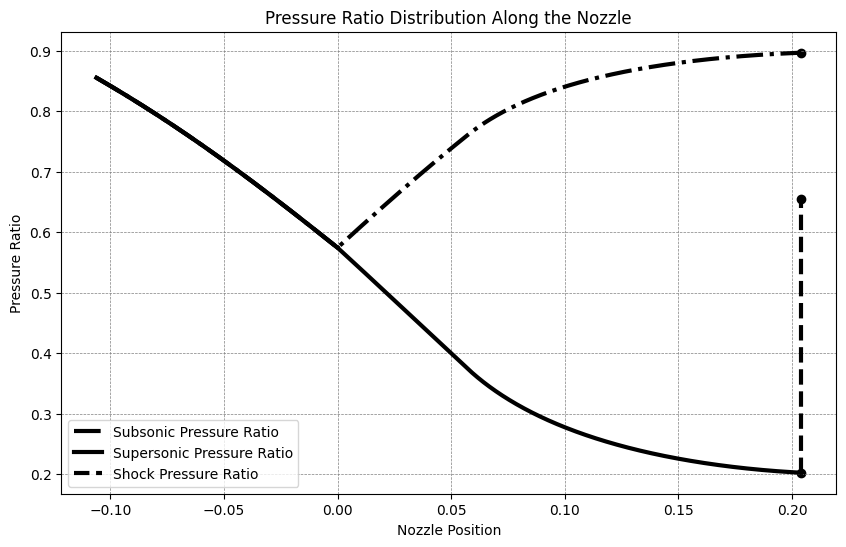

In [6]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import sqlite3 
import json

# Inputs
P1 = 5e5
n = 1000

#specInputs = [K1, K2, theta_n, theta_e, %L, %V]
specInputs = [0.5, 0.382, 30, 6, 0.8, 0.5]

class BellNozzle:
    def __init__(self, defCheck, P1, n, ENGINE, specInputs):
        self.P1 = P1
        self.n = n

        self.engine_Data = self.get_engine_data(ENGINE)

        self.propellant = self.engine_Data["Propellant"]
        self.P0         = self.engine_Data["P0"]
        self.Rt         = self.engine_Data["Rt"]

        self.mass       = self.engine_Data["totalMass"]
        self.time       = self.engine_Data["totalTime"]

        self.t          = self.engine_Data["tree_data"]["Tiempo (s)"]
        self.P_t        = self.engine_Data["tree_data"]["Presi\u00f3n (Pa)"]
        self.G_t        = self.engine_Data["tree_data"]["Flujo M\u00e1sico (kg/s)"]
        self.M_t        = self.engine_Data["tree_data"]["Masa (kg)"]

        if defCheck:
            self.G      = self.engine_Data["meanMassFlow"]
        else:
            self.G      = self.interpolate_mass_flow(self.P1)
        
        self.propellant_Data = self.get_propellant_data()

        self.gamma = self.propellant_Data['gamma']
        self.R = self.propellant_Data['R']
        self.T1 = self.propellant_Data['T_ad']
        self.cChar = self.propellant_Data['cChar']

        self.M2 = np.sqrt((2 / (self.gamma - 1)) * ((self.P1 / self.P0)**((self.gamma - 1)/self.gamma) - 1))
        self.e  = (1/self.M2) * ((2/(self.gamma + 1))*(1 + ((self.gamma - 1)/2) * self.M2**2))**((self.gamma + 1)/(2*(self.gamma - 1)))
        self.T2 = self.T1 / (1 + ((self.gamma - 1)/2) * self.M2**2)
        self.V2 = self.M2 * np.sqrt(self.gamma * self.R * self.T2)
        self.R2 = self.Rt * np.sqrt(self.e)
        self.F = self.G * self.V2
        self.F_kg = self.G * self.V2 / 9.80665

        self.A2 = np.pi * self.R2**2
        self.At = np.pi * self.Rt**2

        self.K1 = specInputs[0]
        self.K2 = specInputs[1]
        self.theta_n = np.deg2rad(specInputs[2])
        self.theta_e = np.deg2rad(specInputs[3])
        self.percL = specInputs[4]
        self.percV = specInputs[5]

        self.thList = np.linspace(-np.pi/2 * (1 + self.percV), self.theta_n - np.pi/2, int(self.n/2))
        self.throatIndex = np.argmin(np.abs(self.thList + np.pi/2)) + 1
        self.geo_Throat = np.array([self.f_throat(th) for th in self.thList])

        self.Nx, self.Ny = self.f_throat(self.theta_n - np.pi/2)
        self.Ex, self.Ey = self.percL * ((np.sqrt(self.e) - 1) * self.Rt) / np.tan(self.theta_n/2), np.sqrt(self.e) * self.Rt
        self.m1, self.m2 = np.tan(self.theta_n), np.tan(self.theta_e)
        self.C1, self.C2 = self.Ny - self.m1 * self.Nx, self.Ey - self.m2 * self.Ex
        self.Qx, self.Qy = (self.C2 - self.C1) / (self.m1 - self.m2), (self.C2 * self.m1 - self.C1 * self.m2) / (self.m1 - self.m2)

        tList = np.linspace(0, 1, int(self.n/2))
        self.geo_Bell = np.array([self.f_bell(t) for t in tList])
        self.geo_Nozzle = np.concatenate((self.geo_Throat, self.geo_Bell))


        self.AR_x = self.geo_Nozzle[:,1]**2 / self.Rt**2

        self.M_x_Sup = np.array([
            fsolve(self.f_AR, 1.75, args=(AR,))[0] if i > self.throatIndex else fsolve(self.f_AR, 1e-6, args=(AR,))[0]
            for i, AR in enumerate(self.AR_x)
        ])

        self.M_eSub = np.sqrt((1 + (self.gamma - 1)/2 * self.M2**2) / (self.gamma * self.M2**2 - (self.gamma - 1)/2))
        self.M_x_Sub = np.array([fsolve(self.f_AR, 1e-6, args=(AR,))[0] for AR in self.AR_x])

        
        self.PR_crit = (self.gamma/2 + 0.5)**(self.gamma/(self.gamma-1))

        self.PRatio_Sub_Curve = self.P_ratio(self.M_x_Sub)**-1
        self.PRatio_Sup_Curve = self.P_ratio(self.M_x_Sup)**-1

        PRatio_2_sho = (1 + (2 * self.gamma / (self.gamma + 1)) * (self.M2**2 - 1))
        PRatio_2_exp = ((1 + (self.gamma - 1)/2 * self.M2**2)**(self.gamma/(self.gamma - 1)))
        
        self.PRatio_1 = self.PRatio_Sub_Curve[-1]
        self.PRatio_2 = PRatio_2_sho / PRatio_2_exp
        self.PRatio_3 = self.PRatio_Sup_Curve[-1]

        

    def opPoint_plot(self,P_Off):

        PR_OffD     =   round(self.P0/P_Off,    6)
        PR_Crit0    =   round(self.PR_crit**-1, 6)
        PR_Crit1    =   round(self.PRatio_1,    6)
        PR_Crit2    =   round(self.PRatio_2,    6)
        PR_Crit3    =   round(self.PRatio_3,    6)

        def noFireOperation():
            Mx = [0,0]
            Px = [1,1]
            xNozzle = [self.geo_Nozzle[0, 0], self.geo_Nozzle[-1, 0]]
            dic = {'Mach':Mx, 'PR':Px, 'x':xNozzle}

            return dic

        def subSonicOperation(P_Off):
            Mt = np.sqrt((2/(self.gamma - 1)) * ((P_Off/self.P0)**((self.gamma - 1)/self.gamma) - 1))
            At_Astar = self.f_AR(Mt, 0)   
            Ax_Astar = self.AR_x * At_Astar
            Mx = np.array([fsolve(self.f_AR, 0.25, args=(AR,))[0] for AR in Ax_Astar])
            Px = self.P_ratio(Mx)**-1
            xNozzle = self.geo_Nozzle[:, 0]
            dic = {'Mach':Mx, 'PR':Px, 'x':xNozzle}

            return dic
        
        def inShockOperation(P_Off):
            x = self.geo_Nozzle[self.throatIndex:,0]
            AR = self.AR_x[self.throatIndex:]
            f_ARx = interp1d(x, AR, kind='linear')
            x_guess = x[-1]
            maxIters = 1e4
            i = 0

            while i < maxIters:
                AR = f_ARx(x_guess)
                M1 = fsolve(self.f_AR, 2.0, args=(AR,))[0]

                P1_P0 = self.P_ratio(M1)**-1
                P2_P1 = 1 + 2 * (self.gamma / (self.gamma + 1)) * (M1**2 - 1)
                M2 = self.M2NS(M1)
                P2t_P2 = self.P_ratio(M2)

                A2_A2star = self.f_AR(M2, 0)
                Ae_A2 = self.R2**2 / (AR * self.At)
                Ae_A2star = A2_A2star * Ae_A2

                Me = fsolve(self.f_AR, 1e-6, args=(Ae_A2star,))[0]
                Pe_P2t = self.P_ratio(Me)**-1

                Pe_P0 = P1_P0 * P2_P1 * P2t_P2 * Pe_P2t
                Pe = Pe_P0 * P_Off

                
                err = abs(Pe - self.P0)

                if abs(Pe - self.P0) < 1e-1:
                    break
                elif Pe < self.P0:
                    x_guess -=  0.01 * err/self.P0
                elif Pe > self.P0:
                    x_guess +=  0.01 * err/self.P0
                
                i += 1

            xIndex = abs(x - x_guess).argmin() + self.throatIndex
            AR_2NS = A2_A2star * self.AR_x[xIndex-1:] / (AR)
            
            MSub_Tr = np.array([fsolve(self.f_AR, 1e-6, args=(AR,))[0] for AR in self.AR_x[:self.throatIndex]])
            MSup_NS = np.array([fsolve(self.f_AR, 2.0, args=(AR,))[0] for AR in self.AR_x[self.throatIndex:xIndex]])
            MSub_NS = np.array([fsolve(self.f_AR, 1e-6, args=(AR,))[0] for AR in AR_2NS])
            Mx = np.concatenate((MSub_Tr, MSup_NS, MSub_NS))

            P2t_P1t = self.P_ratio(M2) * P2_P1 * self.P_ratio(M1)**-1
            PRSub_Tr = self.P_ratio(MSub_Tr)**-1
            PRSup_NS = self.P_ratio(MSup_NS)**-1
            PRSub_NS = self.P_ratio(MSub_NS)**-1 * P2t_P1t
            Px = np.concatenate((PRSub_Tr, PRSup_NS, PRSub_NS))

            xNozzle_Sub = self.geo_Nozzle[:self.throatIndex, 0]
            xNozzle_Sup_NS = self.geo_Nozzle[self.throatIndex:xIndex, 0]
            xNozzle_Sub_NS = self.geo_Nozzle[xIndex-1:, 0]
            xNozzle = np.concatenate((xNozzle_Sub, xNozzle_Sup_NS, xNozzle_Sub_NS))

            dic = { 'Mach':Mx, 'PR':Px, 'x':xNozzle}

            return dic
        
        def exitShockOperation():
            Mx = self.M_x_Sup
            Me = self.M2NS(Mx[-1])
            Px = self.PRatio_Sup_Curve
            Mx = np.append(Mx, Me)
            Px = np.append(Px, PR_Crit2)
            xNozzle = np.append(self.geo_Nozzle[:,0], self.geo_Nozzle[-1,0])
            dic = {'Mach':Mx,'PR':Px,'x':xNozzle}

            return dic
        
        def overExpansionOperation(P_Off):
            Me = self.M2
            Pe = P_Off / self.P_ratio(Me)
            Pe_P0 = Pe / self.P0
            Mx = np.concatenate((self.M_x_Sup, [Me, Me]))
            Px = np.concatenate((self.P_ratio(self.M_x_Sup)**-1 , [PR_Crit3, PR_Crit3 + PR_Crit2 * (1 - Pe_P0)]))
            xNozzle = np.concatenate((self.geo_Nozzle[:,0], [self.geo_Nozzle[-1,0],self.geo_Nozzle[-1,0]]))
            dic = { 'Mach':Mx, 'PR':Px, 'x':xNozzle, 'Pe':Pe}

            return dic
        
        def desingPointOperation(P_Off):
            Pe = P_Off / self.P_ratio(self.M2)
            dic = { 'Mach':self.M_x_Sup, 'PR':self.P_ratio(self.M_x_Sup)**-1, 'x':self.geo_Nozzle[:,0], 'Pe':Pe}

            return dic

        def underExpOperation(P_Off):
            Me = self.M2
            Pe = P_Off / self.P_ratio(Me)
            Mx = np.concatenate((self.M_x_Sup, [Me, Me]))
            Px = np.concatenate((self.P_ratio(self.M_x_Sup)**-1 , [PR_Crit3, self.P0 / P_Off]))
            xNozzle = np.concatenate((self.geo_Nozzle[:,0], [self.geo_Nozzle[-1,0],self.geo_Nozzle[-1,0]]))
            dic = {'Mach':Mx, 'PR':Px, 'x':xNozzle, 'Pe':Pe}

            return dic

        
        subSonicOp = subSonicOperation(P_Off)
        
        try:
            inShockOp = inShockOperation(P_Off)
        except ValueError:
            inShockOp = {'PR':[0,0]}

        exitShockOp = exitShockOperation()
        overExpOp = overExpansionOperation(P_Off)
        desingOp = desingPointOperation(P_Off)
        underExpOp = underExpOperation(P_Off)

        if PR_OffD >= 1:
            return noFireOperation()

        elif PR_OffD >= PR_Crit0 and subSonicOp['PR'][-1] >= PR_Crit1:
            return subSonicOp
        
        elif inShockOp['PR'][-1] >= PR_Crit2:

            if abs(inShockOp['PR'][-1] - PR_Crit2) < 1e-2:
                return exitShockOp
            else:
                return inShockOp
            
        elif overExpOp['Pe'] < self.P0:
            return overExpOp
        
        elif abs(desingOp['Pe'] - self.P0) < 1e-2:
            return desingOp
        
        elif underExpOp['Pe'] > self.P0:
            return underExpOp
        
        else:
            return None

    
    def f_throat(self, th):
        if  -np.pi/2 * (1 + self.percV) <= th < - np.pi/2:
            x = self.K1 * self.Rt * np.cos(th)
            y = self.K1 * self.Rt * np.sin(th) + self.K1 * self.Rt + self.Rt
        elif - np.pi/2 <= th <= self.theta_n - np.pi/2:
            x = self.K2 * self.Rt * np.cos(th)
            y = self.K2 * self.Rt * np.sin(th) + self.K2 * self.Rt + self.Rt
        return x,y
    
    def f_bell(self, t):
        x = (1 - t)**2 * self.Nx + 2 * (1 - t) * t * self.Qx + t**2 * self.Ex
        y = (1 - t)**2 * self.Ny + 2 * (1 - t) * t * self.Qy + t**2 * self.Ey
        return x,y
    
    def f_AR(self, M, AR):
        return (1 / M) * ((2/(self.gamma + 1)) * (1 + ((self.gamma - 1)/2) * M**2))**((self.gamma + 1)/(2*(self.gamma - 1))) - AR
    
    def P_ratio(self, M):
        return (1 + ((self.gamma - 1)/2) * M**2)**(self.gamma/(self.gamma - 1))
    
    def M2NS(self,M1):
        M2_Num = np.sqrt(1 + (self.gamma - 1)/2 * M1**2)
        M2_Den = np.sqrt(self.gamma * M1**2 - (self.gamma - 1)/2)
        return M2_Num / M2_Den

    def get_engine_data(self, ENG):
        # Ruta al archivo JSON
        with open('temp_dir.txt', 'r') as txt:
            dir = txt.readline()
        file_path =  dir + '\\Engines\\' + ENG + '.json'
        print(file_path)
        # Abrir y cargar el archivo JSON
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data

    def get_propellant_data(self):
        conn = sqlite3.connect('database.db')
        cursor = conn.cursor()
        query = "SELECT gamma, R, T_ad, cChar FROM propelente WHERE Propelente = ?"
        cursor.execute(query, (self.propellant,))
        resultado = cursor.fetchone()
        conn.close()
        if resultado:
            props = {
                "gamma":    float(resultado[0]),
                "R":        float(resultado[1]),
                "T_ad":     float(resultado[2]),
                "cChar":    float(resultado[3])
            }
            return props
        else:
            # Retornar None si no se encuentra el propelente
            return None

    def interpolate_mass_flow(self, P1):
        interpolate_time = interp1d(self.P_t, self.t, bounds_error=False, fill_value="extrapolate")
        time_value = interpolate_time(P1)
        interpolate_mass_flow = interp1d(self.t, self.G_t, bounds_error=False, fill_value="extrapolate")
        G_value = interpolate_mass_flow(time_value)
        return G_value
    
    def geom_plot(self):
        fig, ax = plt.subplots(figsize=(10, 6))

        index_i = 0
        index_t = self.throatIndex
        index_n = len(self.geo_Throat)
        index_e = -1

        K1_y = (1 + self.K1) * self.Rt
        K2_y = (1 + self.K2) * self.Rt

        max_y = np.array([K1_y, K2_y, self.geo_Nozzle[index_i, 1], self.geo_Nozzle[index_e, 1]]) 
        max_y = np.max(max_y)

        # Graficar la geometría de la tobera
        ax.plot(self.geo_Nozzle[:, 0], self.geo_Nozzle[:, 1], color='k', lw=3)

        # Asegurarse de que los puntos sean visibles
        ax.scatter(self.geo_Nozzle[index_i, 0], self.geo_Nozzle[index_i, 1], color='k', zorder=5)
        ax.scatter(self.geo_Nozzle[index_t, 0], self.geo_Nozzle[index_t, 1], color='k', zorder=5)
        ax.scatter(self.geo_Nozzle[index_n, 0], self.geo_Nozzle[index_n, 1], color='k', zorder=5)
        ax.scatter(self.geo_Nozzle[index_e, 0], self.geo_Nozzle[index_e, 1], color='k', zorder=5)

        ax.set_xlabel(r'$x(m)$')
        ax.set_ylabel(r'$y(m)$')
        ax.set_title('TOP-Nozzle')
        ax.axis('equal')
        ax.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
        plt.show()
    
    def mach_plot(self, P_Off=0):
        fig, ax = plt.subplots(figsize=(10, 6))

        # Map On-Design
        xNozzle = self.geo_Nozzle[:, 0]
        xExit = self.geo_Nozzle[-1, 0]
        subM = self.M_x_Sub
        supM = self.M_x_Sup
        AShock_M = self.M_eSub

        ax.plot(xNozzle[:self.throatIndex], subM[:self.throatIndex], color='k', lw=3)
        ax.plot(xNozzle, subM, label='Subsonic Mach', color='k', lw=3, linestyle='-.')
        ax.plot(xNozzle, supM, label='Supersonic Mach', color='k', lw=3)
        ax.plot([xExit]*2, [supM[-1], AShock_M], label='Shock Mach', color='k', lw=3, linestyle='--')

        ax.scatter(xExit, subM[-1], color='k', marker='o')
        ax.scatter(xExit, supM[-1], color='k', marker='o')
        ax.scatter(xExit, AShock_M, color='k', marker='o')

        if P_Off:
            offDesing_Dic = self.opPoint_plot(P_Off)
            offDesing_Mach = offDesing_Dic.get("Mach", [])
            xNozzle_off = offDesing_Dic.get("x", [])
            ax.plot(xNozzle_off, offDesing_Mach, label='Off-Design Mach', linestyle='--', color='tab:red', lw=3)
            ax.scatter(xNozzle_off[-1], offDesing_Mach[-1], color='tab:red')

        ax.set_xlabel('Nozzle Position')
        ax.set_ylabel('Mach Number')
        ax.set_title('Mach Number Distribution Along the Nozzle')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
        plt.show()

    def pres_plot(self, P_Off=0):
        fig, ax = plt.subplots(figsize=(10, 6))

        # Map On-Design
        xNozzle = self.geo_Nozzle[:, 0]
        xExit = self.geo_Nozzle[-1, 0]
        subPR = self.PRatio_Sub_Curve
        supPR = self.PRatio_Sup_Curve
        AShock_PR = self.PRatio_2

        ax.plot(xNozzle[:self.throatIndex], subPR[:self.throatIndex], color='k', lw=3)
        ax.plot(xNozzle, subPR, label='Subsonic Pressure Ratio', color='k', lw=3, linestyle='-.')
        ax.plot(xNozzle, supPR, label='Supersonic Pressure Ratio', color='k', lw=3)
        ax.plot([xExit]*2, [supPR[-1], AShock_PR], label='Shock Pressure Ratio', color='k', lw=3, linestyle='--')

        ax.scatter(xExit, subPR[-1], color='k', marker='o')
        ax.scatter(xExit, supPR[-1], color='k', marker='o')
        ax.scatter(xExit, AShock_PR, color='k', marker='o')

        if P_Off:
            offDesing_Dic = self.opPoint_plot(P_Off)
            offDesing_Pres = offDesing_Dic.get("PR", [])
            xNozzle_off = offDesing_Dic.get("x", [])
            ax.plot(xNozzle_off, offDesing_Pres, label='Off-Design Pressure Ratio', linestyle='--', color='tab:red', lw=3)
            ax.scatter(xNozzle_off[-1], offDesing_Pres[-1], color='tab:red')

        ax.set_xlabel('Nozzle Position')
        ax.set_ylabel('Pressure Ratio')
        ax.set_title('Pressure Ratio Distribution Along the Nozzle')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
        plt.show()

    

    

bn = BellNozzle(False, P1, n, 'Test-Engine', specInputs)

bn.pres_plot()



In [77]:
gamma = 1.4
P0 = 5e5
Pb = 101325

def ARf(x):
    return 9 * x**2 + 6 * x + 1

def R(x):
    return 1.5 * x + 0.5

def ARfunc(M, AR):
    return (1 / M) * ((2/(gamma + 1)) * (1 + ((gamma - 1)/2) * M**2))**((gamma + 1)/(2*(gamma - 1))) - AR

def PR(M):
    return (1 + ((gamma - 1)/2) * M**2)**(gamma/(gamma - 1))

def M2NS(M1):
    M2_Num = np.sqrt(1 + (gamma - 1)/2 * M1**2)
    M2_Den = np.sqrt(gamma * M1**2 - (gamma - 1)/2)
    return M2_Num / M2_Den


xGuess = 0.51

for i in range(1000):
    AR = ARf(xGuess)
    M1 = fsolve(ARfunc, 2.0, args=(AR,))[0]

    P1_P0 = PR(M1)**-1
    P2_P1 = 1 + 2 * (gamma / (gamma + 1)) * (M1**2 - 1)
    M2 = M2NS(M1)
    P2t_P2 = PR(M2)

    A2_A2star = ARfunc(M2, 0)
    Ae_A2 = R(1)**2 / R(xGuess)**2
    Ae_A2star = A2_A2star * Ae_A2

    Me = fsolve(ARfunc, 1e-6, args=(Ae_A2star,))[0]
    Pe_P2t = PR(Me)**-1

    Pe_P0 = P1_P0 * P2_P1 * P2t_P2 * Pe_P2t
    Pe = Pe_P0 * P0

    print(xGuess, Pe, Pb, i)
    err = abs(Pe - Pb)

    if abs(Pe - Pb) < 1e-3:
        break
    elif Pe < Pb:
        xGuess -=  0.01 * err/Pb
    elif Pe > Pb:
        xGuess +=  0.01 * err/Pb

Pe/P0,Pb/P0

0.51 110383.91344317868 101325 0
0.510894045244824 110159.05317217896 101325 1
0.5117658985063269 109940.38792946978 101325 2
0.5126161711862647 109727.71653633508 101325 3
0.5134454548315975 109520.84588247613 101325 4
0.514254321930781 109319.59052446653 101325 5
0.5150433266704274 109123.7723083026 101325 6
0.5158130056547159 108933.22001436686 101325 7
0.5165638785897632 108747.76902324906 101325 8
0.5172964489350135 108567.26100099618 101325 9
0.5180112045235647 108391.543602473 101325 10
0.5187086181532191 108220.47019161626 101325 11
0.5193891481499244 108053.89957745819 101325 12
0.5200532389051633 107891.69576488284 101325 13
0.5207013213887441 107733.72771915245 101325 14
0.5213338136383521 107579.86914331625 101325 15
0.5219511212271324 107429.99826767677 101325 16
0.5225536377104955 107283.99765055031 101325 17
0.5231417450532588 107141.75398961357 101325 18
0.5237158140381701 107003.15794317673 101325 19
0.524276204656791 106868.10396077289 101325 20
0.5248232664836623 106

(0.20265000196591978, 0.20265)

In [1]:
import tkinter as tk
import customtkinter as ctk

class ArraySlider(ctk.CTk):
    def __init__(self, array, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.array = array
        self.slider = ctk.CTkSlider(self, from_=0, to=len(array)-1, number_of_steps=len(array)-1, command=self.on_slide)
        self.slider.pack(pady=20)

        self.label = ctk.CTkLabel(self, text=str(array[0]))
        self.label.pack(pady=20)

    def on_slide(self, value):
        index = int(round(value))
        self.label.configure(text=str(self.array[index]))

if __name__ == "__main__":
    app = ArraySlider([10, 20, 30, 40, 50])
    app.mainloop()

In [2]:
[10, 20, 30, 40, 50][1:]

[20, 30, 40, 50]